# English-to-Spanish translation with a sequence-to-sequence Transformer

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2021/05/26<br>
**Last modified:** 2024/11/18<br>
**Description:** Implementing a sequence-to-sequence Transformer and training it on a machine translation task.

## Introduction

In this example, we'll build a sequence-to-sequence Transformer model, which
we'll train on an English-to-Spanish machine translation task.

You'll learn how to:

- Vectorize text using the Keras `TextVectorization` layer.
- Implement a `TransformerEncoder` layer, a `TransformerDecoder` layer,
and a `PositionalEmbedding` layer.
- Prepare data for training a sequence-to-sequence model.
- Use the trained model to generate translations of never-seen-before
input sentences (sequence-to-sequence inference).

The code featured here is adapted from the book
[Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)
(chapter 11: Deep learning for text).
The present example is fairly barebones, so for detailed explanations of
how each building block works, as well as the theory behind Transformers,
I recommend reading the book.

## Setup

In [1]:
# We set the backend to TensorFlow. The code works with
# both `tensorflow` and `torch`. It does not work with JAX
# due to the behavior of `jax.numpy.tile` in a jit scope
# (used in `TransformerDecoder.get_causal_attention_mask()`:
# `tile` in JAX does not support a dynamic `reps` argument.
# You can make the code work in JAX by wrapping the
# inside of the `get_causal_attention_mask` method in
# a decorator to prevent jit compilation:
# `with jax.ensure_compile_time_eval():`.
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization

## Downloading the data

We'll be working with an English-to-Spanish translation dataset
provided by [Anki](https://www.manythings.org/anki/). Let's download it:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

os.chdir("/content/drive/MyDrive/Diplomado_IA/NLP/Keras Translator")

In [4]:
text_file = "spa.txt"

## Parsing the data

Each line contains an English sentence and its corresponding Spanish sentence.
The English sentence is the *source sequence* and Spanish one is the *target sequence*.
We prepend the token `"[start]"` and we append the token `"[end]"` to the Spanish sentence.

In [5]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

text_pairs = []

for i in range(0, len(lines)):
  eng, spa = lines[i].split("\t")[0], lines[i].split("\t")[1]
  spa = "[start] " + spa + " [end]"
  text_pairs.append((eng, spa))

Here's what our sentence pairs look like:

In [6]:
for _ in range(5):
    print(random.choice(text_pairs))

('We need to find out what it is.', '[start] Tenemos que encontrar qué es lo que es. [end]')
("There's a slight difference.", '[start] Hay una leve diferencia. [end]')
('To each his own.', '[start] A cada cual lo que se merece. [end]')
('Your answer is right.', '[start] Tu respuesta es correcta. [end]')
('Her family moved to Brazil.', '[start] Su familia se mudó a Brasil. [end]')


Now, let's split the sentence pairs into a training set, a validation set,
and a test set.

In [7]:
random.shuffle(text_pairs)

num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples

train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

141543 total pairs
99081 training pairs
21231 validation pairs
21231 test pairs


## Vectorizing the text data

We'll use two instances of the `TextVectorization` layer to vectorize the text
data (one for English and one for Spanish),
that is to say, to turn the original strings into integer sequences
where each integer represents the index of a word in a vocabulary.

The English layer will use the default string standardization (strip punctuation characters)
and splitting scheme (split on whitespace), while
the Spanish layer will use a custom standardization, where we add the character
`"¿"` to the set of punctuation characters to be stripped.

Note: in a production-grade machine translation model, I would not recommend
stripping the punctuation characters in either language. Instead, I would recommend turning
each punctuation character into its own token,
which you could achieve by providing a custom `split` function to the `TextVectorization` layer.

In [8]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]

eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

In [9]:
display(eng_vectorization.get_vocabulary()[10:15])
display(spa_vectorization.get_vocabulary()[10:15])

[np.str_('in'), np.str_('that'), np.str_('of'), np.str_('it'), np.str_('do')]

[np.str_('el'), np.str_('es'), np.str_('en'), np.str_('un'), np.str_('me')]

In [10]:
# trying to vectorize a dummy sentence

output = eng_vectorization([["the cat sat on the mat"]])
display(output.numpy()[0, :6])

output = spa_vectorization([["[start] el gato está en el mantel [end]"]])
display(output.numpy()[0, :7]) #que se note que aquí imprimí uno más por el bloque de "start"

array([   3,  345,  605,   32,    3, 5193])

array([    2,    10,   309,    20,    12,    10, 11747])

In [11]:
eng_voc = eng_vectorization.get_vocabulary()
eng_word_index = dict(zip(eng_voc, range(len(eng_voc))))


spa_voc = spa_vectorization.get_vocabulary()
spa_word_index = dict(zip(spa_voc, range(len(spa_voc))))

In [12]:
len(eng_voc), len(spa_voc)

(12859, 15000)

In [13]:
eng_test = ["the", "cat", "sat", "on", "the", "mat"]
display([eng_word_index[w] for w in eng_test])

# it worksssss!!!!! jejeje, en español debería ser lo mismo...

spa_test = ["el", "gato", "está", "en", "el", "mantel"]
display([spa_word_index[w] for w in spa_test])

[3, 345, 605, 32, 3, 5193]

[10, 309, 20, 12, 10, 11747]

## importing glove embedding:

ya lo había descargado y descomprimido, entonces omitiré esos pasos...

In [14]:
import numpy as np

path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [15]:
eng_voc_size = len(eng_voc) + 2

In [16]:
eng_num_tokens = len(eng_voc) + 2
eng_embedding_dim = 100
eng_hits = 0
eng_misses = 0

# Prepare embedding matrix
eng_embedding_matrix = np.zeros((eng_num_tokens, eng_embedding_dim))
for word, i in eng_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        eng_embedding_matrix[i] = embedding_vector
        eng_hits += 1
    else:
        eng_misses += 1
print("Converted %d words (%d misses)" % (eng_hits, eng_misses))

Converted 12526 words (333 misses)


In [17]:
eng_embedding_matrix[2:5]

array([[-4.65390012e-02,  6.19660020e-01,  5.66470027e-01,
        -4.65840012e-01, -1.18900001e+00,  4.45989996e-01,
         6.60350025e-02,  3.19099993e-01,  1.46789998e-01,
        -2.21190006e-01,  7.92389989e-01,  2.99050003e-01,
         1.60730004e-01,  2.53240000e-02,  1.86780006e-01,
        -3.10009986e-01, -2.81080008e-01,  6.05149984e-01,
        -1.06540000e+00,  5.24760008e-01,  6.41520023e-02,
         1.03579998e+00, -4.07790005e-01, -3.80109996e-01,
         3.08010012e-01,  5.99640012e-01, -2.69910008e-01,
        -7.60349989e-01,  9.42219973e-01, -4.69190001e-01,
        -1.82779998e-01,  9.06520009e-01,  7.96710014e-01,
         2.48249993e-01,  2.57129997e-01,  6.23199999e-01,
        -4.47679996e-01,  6.53569996e-01,  7.69020021e-01,
        -5.12290001e-01, -4.43329990e-01, -2.18669996e-01,
         3.83700013e-01, -1.14830005e+00, -9.43979979e-01,
        -1.50619999e-01,  3.00119996e-01, -5.78059971e-01,
         2.01749995e-01, -1.65910006e+00, -7.91950002e-0

Desde acá comienza el código de chollet

In [18]:
train_pairs[1:5]

[("They're trapped.", '[start] Ellos están atrapados. [end]'),
 ('We have plenty of food.', '[start] Tenemos un montón de comida. [end]'),
 ("I thought that we'd worry about that later.",
  '[start] Pensé que nos preocuparíamos por eso más tarde. [end]'),
 ('To master English is hard.', '[start] Es difícil dominar el inglés. [end]')]

In [19]:

def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Let's take a quick look at the sequence shapes
(we have batches of 64 pairs, and all sequences are 20 steps long):

In [20]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


## Building the model

Acá metro otra vez mi mano en el código

In [21]:
import keras.ops as ops


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

## Adding a fixed positional embeffing to add a fixed embedding matrix and a trainable param, in case I want to fix it to FALSE...

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, embedding_matrix=None, trainable=False, **kwargs):
        super().__init__(**kwargs)

        # Token embedding layer (uses pretrained weights if provided)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            trainable=trainable
        )

        # If a pre-trained embedding matrix is provided, set it
        if embedding_matrix is not None:
            self.token_embeddings.build((None,))  # Build the layer
            self.token_embeddings.set_weights([embedding_matrix])  # Load pre-trained weights

        # Position embedding layer (randomly initialized)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length,
            output_dim=embed_dim
        )

        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]  # Get sequence length dynamically
        positions = ops.arange(0, length, 1)  # Generate position indices
        embedded_tokens = self.token_embeddings(inputs)  # Token embeddings
        embedded_positions = self.position_embeddings(positions)  # Positional embeddings
        return embedded_tokens + embedded_positions  # Sum embeddings

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)  # Mask padding tokens (0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim
        })
        return config



class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        inputs, encoder_outputs = inputs
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is None:
            inputs_padding_mask, encoder_outputs_padding_mask = None, None
        else:
            inputs_padding_mask, encoder_outputs_padding_mask = mask

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
            query_mask=inputs_padding_mask,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            query_mask=inputs_padding_mask,
            key_mask=encoder_outputs_padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


Next, we assemble the end-to-end model.

In [22]:
sequence_length, vocab_size

(20, 15000)

In [23]:
embed_dim = 100
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, eng_voc_size, embed_dim, embedding_matrix=eng_embedding_matrix, trainable=False)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim, trainable = True)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)([x, encoder_outputs])
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

transformer = keras.Model(
    {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
    decoder_outputs,
    name="transformer",
)

## Training our model

We'll use accuracy as a quick way to monitor training progress on the validation data.
Note that machine translation typically uses BLEU scores as well as other metrics, rather than accuracy.

Here we only train for 1 epoch, but to get the model to actually converge
you should train for at least 30 epochs.

In [24]:
epochs = 30  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop",
    loss=keras.losses.SparseCategoricalCrossentropy(ignore_class=0),
    metrics=["accuracy"],
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding      │ (None, None, 100)      │      1,288,100 │ encoder_inputs[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_1    │ (None, None, 100)      │      1,502,000 │ decoder_inputs[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, None, 100)      │        734,648 │ positional_embedding[… │
│ (TransformerEncoder)      │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, None)           │              0 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder       │ (None, None, 100)      │      1,057,348 │ positional_embedding_… │
│ (TransformerDecoder)      │                        │                │ transformer_encoder[0… │
│                           │                        │                │ not_equal_1[0][0],     │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, None, 100)      │              0 │ transformer_decoder[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, None, 15000)    │      1,515,000 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,097,096 (23.26 MB)

 Trainable params: 4,810,996 (18.35 MB)

 Non-trainable params: 1,286,100 (4.91 MB)

Epoch 1/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/step - accuracy: 0.0858 - loss: 5.5951 - val_accuracy: 0.1700 - val_loss: 3.3269
Epoch 2/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1670 - loss: 3.4611 - val_accuracy: 0.1941 - val_loss: 2.8552
Epoch 3/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1896 - loss: 3.0424 - val_accuracy: 0.2046 - val_loss: 2.7064
Epoch 4/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2009 - loss: 2.8752 - val_accuracy: 0.2098 - val_loss: 2.6305
Epoch 5/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2058 - loss: 2.8066 - val_accuracy: 0.2106 - val_loss: 2.6232
Epoch 6/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2091 - loss: 2.7623 - val_accuracy: 0.2115 - val_loss: 2.6562
Epoch 7/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2122 - loss: 2.7271 - val_accuracy: 0.2139 - val_loss: 2.6120
Epoch 8/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2138 - loss: 

<ipython-input-25-5bb2403c0f43>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-b" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs_range, acc, '-b', label='Training Accuracy', color = 'black')
<ipython-input-25-5bb2403c0f43>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-b" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs_range, loss, '-b', label='Training Loss', color = 'black')


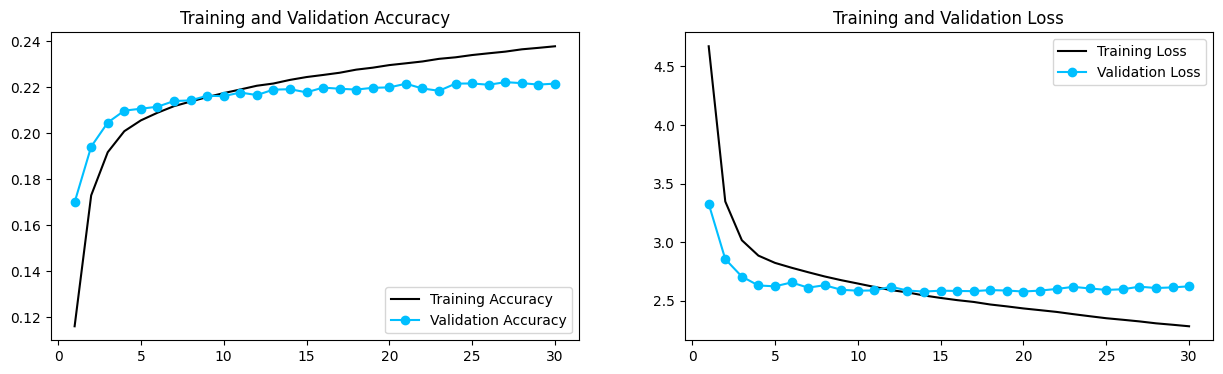

In [25]:
import matplotlib.pyplot as plt

# Plot Training History (Optional but very useful)
acc = transformer.history.history['accuracy']
val_acc = transformer.history.history['val_accuracy']

loss = transformer.history.history['loss']
val_loss = transformer.history.history['val_loss']

epochs_range = range(1, 30+1)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '-b', label='Training Accuracy', color = 'black')
plt.plot(epochs_range, val_acc, '-o' ,label='Validation Accuracy', color = 'deepskyblue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '-b', label='Training Loss', color = 'black')
plt.plot(epochs_range, val_loss, '-o' ,label='Validation Loss', color = 'deepskyblue')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('scratch_AlexNet.jpg')

plt.show()

In [26]:
transformer.save("zoe_GloVe_model_30_epochs.keras")

## Decoding test sentences

Finally, let's demonstrate how to translate brand new English sentences.
We simply feed into the model the vectorized English sentence
as well as the target token `"[start]"`, then we repeatedly generated the next token, until
we hit the token `"[end]"`.

In [27]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer(
            {
                "encoder_inputs": tokenized_input_sentence,
                "decoder_inputs": tokenized_target_sentence,
            }
        )

        # ops.argmax(predictions[0, i, :]) is not a concrete value for jax here
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

    print(input_sentence, "---> ", translated)

Guide dogs help blind people. --->  [start] los perros [UNK] [UNK] a la gente de los que les está de ayudar [end]
Tom told me that he thought Mary knew how to play the flute. --->  [start] tom me dijo que pensé que sabía cómo sabe tocar la tom al no lo no en el no [end]
He turned off the light. --->  [start] Él se quedó sin luz [end]
I was at home all summer. --->  [start] yo estaba en casa todo el verano [end]
Please adopt this puppy. --->  [start] por favor [UNK] este perro [end]
The factory was shut down ten years ago. --->  [start] la fábrica se quedó en una fábrica hace diez años [end]
I have caught a bad cold. --->  [start] me he perdido un mal frío [end]
A young woman was singing and playing the guitar in front of the fountain. --->  [start] una mujer joven estaba llorando y la guitarra jugando en el cuello del ella es el [UNK] [end]
Is there a toilet near here? --->  [start] hay un baño aquí cerca de aquí [end]
That's very sweet of you. --->  [start] eso es muy agradable de ti 

## now running again but without freezing the code:

In [28]:
embed_dim = 100
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, eng_voc_size, embed_dim, embedding_matrix=eng_embedding_matrix, trainable=True)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim, trainable=True)(decoder_inputs)

x = TransformerDecoder(embed_dim, latent_dim, num_heads)([x, encoder_outputs])
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

transformer = keras.Model(
    {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
    decoder_outputs,
    name="transformer",
)

In [29]:
epochs = 30  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop",
    loss=keras.losses.SparseCategoricalCrossentropy(ignore_class=0),
    metrics=["accuracy"],
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_2    │ (None, None, 100)      │      1,288,100 │ encoder_inputs[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, None)           │              0 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_3    │ (None, None, 100)      │      1,502,000 │ decoder_inputs[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_1     │ (None, None, 100)      │        734,648 │ positional_embedding_… │
│ (TransformerEncoder)      │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, None)           │              0 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder_1     │ (None, None, 100)      │      1,057,348 │ positional_embedding_… │
│ (TransformerDecoder)      │                        │                │ transformer_encoder_1… │
│                           │                        │                │ not_equal_3[0][0],     │
│                           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, None, 100)      │              0 │ transformer_decoder_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, None, 15000)    │      1,515,000 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,097,096 (23.26 MB)

 Trainable params: 6,097,096 (23.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.0869 - loss: 5.5795 - val_accuracy: 0.1709 - val_loss: 3.3095
Epoch 2/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.1706 - loss: 3.4044 - val_accuracy: 0.1980 - val_loss: 2.8093
Epoch 3/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.1936 - loss: 2.9831 - val_accuracy: 0.2071 - val_loss: 2.6326
Epoch 4/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.2038 - loss: 2.8190 - val_accuracy: 0.2136 - val_loss: 2.5917
Epoch 5/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.2094 - loss: 2.7433 - val_accuracy: 0.2127 - val_loss: 2.5899
Epoch 6/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.2136 - loss: 2.7044 - val_accuracy: 0.2151 - val_loss: 2.6027
Epoch 7/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.2161 - loss: 2.6690 - val_accuracy: 0.2181 - val_loss: 2.5754
Epoch 8/30
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.2182 - loss: 

<ipython-input-30-3ff4a45ba303>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-b" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs_range, acc, '-b', label='Training Accuracy', color = 'black')
<ipython-input-30-3ff4a45ba303>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-b" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs_range, loss, '-b', label='Training Loss', color = 'black')


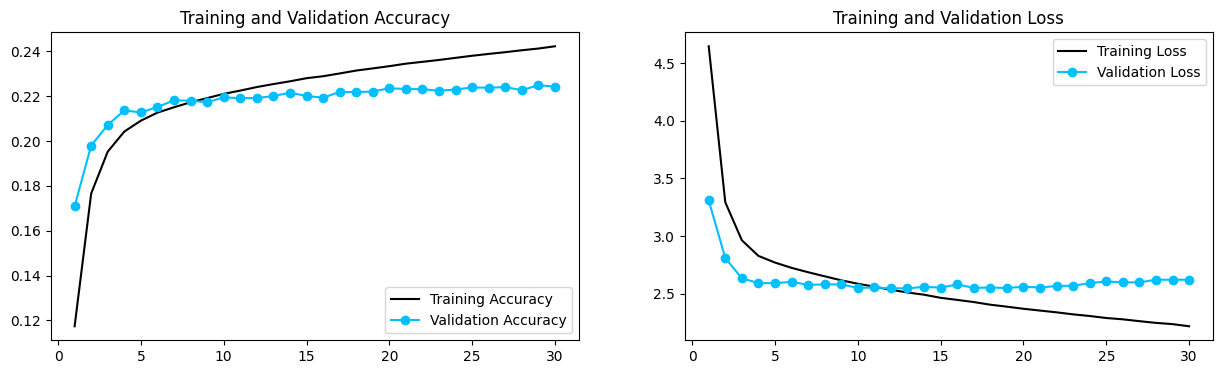

In [30]:
# Plot Training History (Optional but very useful)
acc = transformer.history.history['accuracy']
val_acc = transformer.history.history['val_accuracy']

loss = transformer.history.history['loss']
val_loss = transformer.history.history['val_loss']

epochs_range = range(1, 30+1)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '-b', label='Training Accuracy', color = 'black')
plt.plot(epochs_range, val_acc, '-o' ,label='Validation Accuracy', color = 'deepskyblue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '-b', label='Training Loss', color = 'black')
plt.plot(epochs_range, val_loss, '-o' ,label='Validation Loss', color = 'deepskyblue')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('scratch_AlexNet.jpg')

plt.show()

In [31]:
transformer.save("zoe_GloVe_model_30_epochs_trainable.keras")

In [32]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer(
            {
                "encoder_inputs": tokenized_input_sentence,
                "decoder_inputs": tokenized_target_sentence,
            }
        )

        # ops.argmax(predictions[0, i, :]) is not a concrete value for jax here
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

    print(input_sentence, "---> ", translated)

Here's some medicine for diarrhea. --->  [start] aquí hay alguna remedio para que [UNK] [end]
You're good with kids. --->  [start] eres bueno con los niños [end]
Tom didn't do that right. --->  [start] tom no hizo eso lo justo [end]
I still read every day. --->  [start] todavía he leído todos los días [end]
You can't stop me. --->  [start] no puedes dejar de mí [end]
Where did you hide? --->  [start] dónde te [UNK] [end]
Tom isn't watching TV now. --->  [start] tom no está viendo la televisión ahora [end]
I'm moving on. --->  [start] me voy a [UNK] [end]
I'll stay at my grandparents' house this weekend. --->  [start] me voy a quedar en esta casa este fin de semana [end]
I didn't steal anything from Tom. --->  [start] no me [UNK] nada de tom [end]
Come on, we're almost there. --->  [start] vamos ven allí casi allí [end]
Is it true you can't speak French? --->  [start] es verdad que no sabes hablar francés [end]
My car's out of gas, so I can't drive anywhere. --->  [start] mi camión se m